In [7]:
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint

In [8]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [9]:
data = pd.concat([train, test],axis=0, sort='False', ignore_index = True)

In [10]:
data = data[data.columns.difference(['Id'])]

In [11]:
ids = test["Id"]

In [12]:
data = data.fillna(0)

In [13]:
#Encoding categorical data
data = pd.get_dummies(data)

In [45]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_0,Alley_Grvl,Alley_Pave,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,TotRmsAbvGrd,TotalBsmtSF,Utilities_0,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,lgb
0,856,854,0,1,0,0,3,1,0,0,...,8,856.0,0,1,0,0,2003,2003,2008,0.318032
1,1262,0,0,1,0,0,3,1,0,0,...,6,1262.0,0,1,0,298,1976,1976,2007,0.008252
2,920,866,0,1,0,0,3,1,0,0,...,6,920.0,0,1,0,0,2001,2002,2008,0.556185
3,961,756,0,1,0,0,3,1,0,0,...,7,756.0,0,1,0,0,1915,1970,2006,-0.440533
4,1145,1053,0,1,0,0,4,1,0,0,...,9,1145.0,0,1,0,192,2000,2000,2008,1.027576


In [15]:
train = data.iloc[:1460,:] #Upto 1460 rows from first
test = data.iloc[1460:,:] # From 1461th row to last
X_train = train[train.columns.difference(['SalePrice'])].values
y_train = train[['SalePrice']].values
X_test = test[test.columns.difference(['SalePrice'])].values

In [16]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler, PowerTransformer
pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
sc_y = StandardScaler()
sc_X = StandardScaler()
y_train = sc_y.fit_transform(y_train)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [17]:
flat_y = y_train.flatten()
flat_y.shape

(1460,)

In [18]:
from sklearn.model_selection import KFold, cross_val_score
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [19]:
import lightgbm as lgb
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, flat_y)
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=250)
# predict
lgbm_prediction_tr = gbm.predict(X_train, num_iteration=gbm.best_iteration)
lgbm_prediction_te = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003649 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [20]:
train["lgb"] = lgbm_prediction_tr
test["lgb"] = lgbm_prediction_te

<ipython-input-20-62b945ab7fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["lgb"] = lgbm_prediction_tr
<ipython-input-20-62b945ab7fd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["lgb"] = lgbm_prediction_te


In [21]:
y_pred = sc_y.inverse_transform(lgbm_prediction_te)

In [22]:
y_pred

array([125112.61947507, 159941.60061715, 179800.79082196, ...,
       147411.31676378, 115851.43746952, 210385.08884737])

In [23]:
data = pd.concat([train, test],axis=0, sort='False', ignore_index = True)
data = data[data.columns.difference(['Id'])]
train = data.iloc[:1460,:]
test = data.iloc[1460:,:]
X_train = train[train.columns.difference(['SalePrice'])].values
y_train = train[['SalePrice']].values
X_test = test[test.columns.difference(['SalePrice'])].values
pt_X = PowerTransformer(method='yeo-johnson', standardize=False)
sc_y = StandardScaler()
sc_X = StandardScaler()
y_train = sc_y.fit_transform(y_train)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [24]:
#Inıtialising the ANN
model = Sequential()
#Adding the input layer and first hidden layer
model.add(Dense(units =64, kernel_initializer='he_uniform', activation= 'relu', 
                input_dim=X_train.shape[1]))
#Add the second hidden layer
model.add(Dense(units =32, kernel_initializer='he_uniform', activation= 'relu'))
#Add the second hidden layer

model.add(Dense(units =64, kernel_initializer='he_uniform', activation= 'relu'))
#The output layer
model.add(Dense(units =1, kernel_initializer='he_uniform'))

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                20032     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 24,289
Trainable params: 24,289
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
#Compiling the ANN
#opt = keras.optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='Adamax', loss='mean_squared_logarithmic_error', metrics=['mse'])
#Fitting the ANN to the training set
model_filepath = 'min_vl_model.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=1, save_best_only = True, mode='min' )
model.fit(X_train,y_train, validation_split=0.2, batch_size=10, epochs=1000, callbacks=[checkpoint])
model.load_weights(model_filepath)

Epoch 1/1000
105/117 [=========================>....] - ETA: 0s - loss: 0.1246 - mse: 0.9764
Epoch 00001: val_loss improved from inf to 0.08377, saving model to min_vl_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.1184 - mse: 0.9473 - val_loss: 0.0838 - val_mse: 1.1041
Epoch 2/1000
100/117 [========================>.....] - ETA: 0s - loss: 0.0470 - mse: 0.8289
Epoch 00002: val_loss improved from 0.08377 to 0.06824, saving model to min_vl_model.h5
117/117 [==============================] - 0s 4ms/step - loss: 0.0476 - mse: 0.8559 - val_loss: 0.0682 - val_mse: 1.1141
Epoch 3/1000
 95/117 [=======================>......] - ETA: 0s - loss: 0.0333 - mse: 0.7396
Epoch 00003: val_loss improved from 0.06824 to 0.06333, saving model to min_vl_model.h5
117/117 [==============================] - 0s 3ms/step - loss: 0.0362 - mse: 0.8337 - val_loss: 0.0633 - val_mse: 1.1908
Epoch 4/1000
 78/117 [===================>..........] - ETA: 0s - loss: 0.0284 - mse: 0.8085
Epoc

Epoch 30/1000
105/117 [=========================>....] - ETA: 0s - loss: 0.0134 - mse: 0.8111   
Epoch 00030: val_loss did not improve from 0.05544
117/117 [==============================] - 0s 1ms/step - loss: 0.0138 - mse: 0.7904 - val_loss: 0.0560 - val_mse: 1.2087
Epoch 31/1000
109/117 [==========================>...] - ETA: 0s - loss: 0.0143 - mse: 0.7539
Epoch 00031: val_loss improved from 0.05544 to 0.05485, saving model to min_vl_model.h5
117/117 [==============================] - 0s 3ms/step - loss: 0.0137 - mse: 0.7616 - val_loss: 0.0549 - val_mse: 1.2193
Epoch 32/1000
106/117 [==========================>...] - ETA: 0s - loss: 0.0138 - mse: 0.7666   
Epoch 00032: val_loss did not improve from 0.05485
117/117 [==============================] - 0s 1ms/step - loss: 0.0137 - mse: 0.7776 - val_loss: 0.0554 - val_mse: 1.2190
Epoch 33/1000
117/117 [==============================] - ETA: 0s - loss: 0.0137 - mse: 0.7691   
Epoch 00033: val_loss improved from 0.05485 to 0.05466, saving

Epoch 60/1000
 88/117 [=====================>........] - ETA: 0s - loss: 0.0109 - mse: 0.5802
Epoch 00060: val_loss did not improve from 0.05243
117/117 [==============================] - 0s 1ms/step - loss: 0.0121 - mse: 0.5995 - val_loss: 0.0528 - val_mse: 1.0825
Epoch 61/1000
106/117 [==========================>...] - ETA: 0s - loss: 0.0117 - mse: 0.6011
Epoch 00061: val_loss did not improve from 0.05243
117/117 [==============================] - 0s 1ms/step - loss: 0.0123 - mse: 0.5907 - val_loss: 0.0543 - val_mse: 1.0913
Epoch 62/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0128 - mse: 0.6031
Epoch 00062: val_loss did not improve from 0.05243
117/117 [==============================] - 0s 1ms/step - loss: 0.0124 - mse: 0.6010 - val_loss: 0.0537 - val_mse: 1.0799
Epoch 63/1000
117/117 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.6064   
Epoch 00063: val_loss did not improve from 0.05243
117/117 [==============================] - 0s 1ms/step

107/117 [==========================>...] - ETA: 0s - loss: 0.0104 - mse: 0.3767   
Epoch 00120: val_loss did not improve from 0.04970
117/117 [==============================] - 0s 1ms/step - loss: 0.0101 - mse: 0.3619 - val_loss: 0.0501 - val_mse: 0.8374
Epoch 121/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0096 - mse: 0.3630
Epoch 00121: val_loss improved from 0.04970 to 0.04962, saving model to min_vl_model.h5
117/117 [==============================] - 1s 12ms/step - loss: 0.0100 - mse: 0.3617 - val_loss: 0.0496 - val_mse: 0.8424
Epoch 122/1000
103/117 [=========================>....] - ETA: 0s - loss: 0.0102 - mse: 0.3485
Epoch 00122: val_loss did not improve from 0.04962
117/117 [==============================] - 0s 1ms/step - loss: 0.0100 - mse: 0.3572 - val_loss: 0.0497 - val_mse: 0.8437
Epoch 123/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0105 - mse: 0.3651   
Epoch 00123: val_loss did not improve from 0.04962
117/117 [===============

Epoch 179/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0101 - mse: 0.2378   
Epoch 00179: val_loss did not improve from 0.04605
117/117 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 0.2369 - val_loss: 0.0478 - val_mse: 0.7278
Epoch 180/1000
 61/117 [==============>...............] - ETA: 0s - loss: 0.0099 - mse: 0.2401    
Epoch 00180: val_loss did not improve from 0.04605
117/117 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 0.2335 - val_loss: 0.0466 - val_mse: 0.7314
Epoch 181/1000
115/117 [============================>.] - ETA: 0s - loss: 0.0096 - mse: 0.2337   
Epoch 00181: val_loss did not improve from 0.04605
117/117 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 0.2339 - val_loss: 0.0464 - val_mse: 0.7229
Epoch 182/1000
116/117 [============================>.] - ETA: 0s - loss: 0.0099 - mse: 0.2380
Epoch 00182: val_loss did not improve from 0.04605
117/117 [==============================] - 

Epoch 209/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0117 - mse: 0.2489    
Epoch 00209: val_loss did not improve from 0.04483
117/117 [==============================] - 0s 1ms/step - loss: 0.0097 - mse: 0.2113 - val_loss: 0.0454 - val_mse: 0.6884
Epoch 210/1000
 58/117 [=============>................] - ETA: 0s - loss: 0.0106 - mse: 0.2354    
Epoch 00210: val_loss improved from 0.04483 to 0.04430, saving model to min_vl_model.h5
117/117 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.2078 - val_loss: 0.0443 - val_mse: 0.6631
Epoch 211/1000
105/117 [=========================>....] - ETA: 0s - loss: 0.0088 - mse: 0.1985
Epoch 00211: val_loss did not improve from 0.04430
117/117 [==============================] - 0s 1ms/step - loss: 0.0097 - mse: 0.2084 - val_loss: 0.0459 - val_mse: 0.6918
Epoch 212/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0091 - mse: 0.2186    
Epoch 00212: val_loss did not improve from 0.04430
117/

Epoch 239/1000
107/117 [==========================>...] - ETA: 0s - loss: 0.0087 - mse: 0.1901   
Epoch 00239: val_loss did not improve from 0.04430
117/117 [==============================] - 0s 1ms/step - loss: 0.0084 - mse: 0.1829 - val_loss: 0.0458 - val_mse: 0.6730
Epoch 240/1000
101/117 [========================>.....] - ETA: 0s - loss: 0.0069 - mse: 0.1729
Epoch 00240: val_loss did not improve from 0.04430
117/117 [==============================] - 0s 1ms/step - loss: 0.0084 - mse: 0.1837 - val_loss: 0.0456 - val_mse: 0.6859
Epoch 241/1000
 59/117 [==============>...............] - ETA: 0s - loss: 0.0068 - mse: 0.1573    
Epoch 00241: val_loss did not improve from 0.04430
117/117 [==============================] - 0s 1ms/step - loss: 0.0084 - mse: 0.1807 - val_loss: 0.0448 - val_mse: 0.6745
Epoch 242/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0085 - mse: 0.1822
Epoch 00242: val_loss did not improve from 0.04430
117/117 [==============================] - 0s 

Epoch 300/1000
107/117 [==========================>...] - ETA: 0s - loss: 0.0041 - mse: 0.1496
Epoch 00300: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.1507 - val_loss: 0.0484 - val_mse: 0.7020
Epoch 301/1000
108/117 [==========================>...] - ETA: 0s - loss: 0.0043 - mse: 0.1517   
Epoch 00301: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.1485 - val_loss: 0.0479 - val_mse: 0.6890
Epoch 302/1000
108/117 [==========================>...] - ETA: 0s - loss: 0.0042 - mse: 0.1487
Epoch 00302: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.1487 - val_loss: 0.0504 - val_mse: 0.7220
Epoch 303/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0042 - mse: 0.1484   
Epoch 00303: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1

Epoch 331/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0035 - mse: 0.1490  
Epoch 00331: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.1475 - val_loss: 0.0490 - val_mse: 0.6865
Epoch 332/1000
 95/117 [=======================>......] - ETA: 0s - loss: 0.0032 - mse: 0.1425   
Epoch 00332: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0034 - mse: 0.1475 - val_loss: 0.0497 - val_mse: 0.6961
Epoch 333/1000
 92/117 [======================>.......] - ETA: 0s - loss: 0.0030 - mse: 0.1467
Epoch 00333: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.1465 - val_loss: 0.0483 - val_mse: 0.6796
Epoch 334/1000
100/117 [========================>.....] - ETA: 0s - loss: 0.0026 - mse: 0.1431  
Epoch 00334: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 

Epoch 362/1000
 98/117 [========================>.....] - ETA: 0s - loss: 0.0033 - mse: 0.1346   
Epoch 00362: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1397 - val_loss: 0.0488 - val_mse: 0.6707
Epoch 363/1000
107/117 [==========================>...] - ETA: 0s - loss: 0.0030 - mse: 0.1374   
Epoch 00363: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.1408 - val_loss: 0.0486 - val_mse: 0.6679
Epoch 364/1000
104/117 [=========================>....] - ETA: 0s - loss: 0.0037 - mse: 0.1422   
Epoch 00364: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 0.1406 - val_loss: 0.0480 - val_mse: 0.6534
Epoch 365/1000
117/117 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.1409  
Epoch 00365: val_loss did not improve from 0.04398
117/117 [==============================] -

Epoch 393/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0032 - mse: 0.1368   
Epoch 00393: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1367 - val_loss: 0.0493 - val_mse: 0.6597
Epoch 394/1000
110/117 [===========================>..] - ETA: 0s - loss: 0.0033 - mse: 0.1381
Epoch 00394: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1360 - val_loss: 0.0515 - val_mse: 0.6962
Epoch 395/1000
109/117 [==========================>...] - ETA: 0s - loss: 0.0032 - mse: 0.1378   
Epoch 00395: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1359 - val_loss: 0.0482 - val_mse: 0.6506
Epoch 396/1000
114/117 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.1351   
Epoch 00396: val_loss did not improve from 0.04398
117/117 [==============================] - 0

Epoch 424/1000
 59/117 [==============>...............] - ETA: 0s - loss: 0.0022 - mse: 0.1177    
Epoch 00424: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1303 - val_loss: 0.0495 - val_mse: 0.6754
Epoch 425/1000
 63/117 [===============>..............] - ETA: 0s - loss: 0.0033 - mse: 0.1249    
Epoch 00425: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1297 - val_loss: 0.0490 - val_mse: 0.6680
Epoch 426/1000
109/117 [==========================>...] - ETA: 0s - loss: 0.0033 - mse: 0.1310   
Epoch 00426: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.1310 - val_loss: 0.0503 - val_mse: 0.6842
Epoch 427/1000
 98/117 [========================>.....] - ETA: 0s - loss: 0.0029 - mse: 0.1263   
Epoch 00427: val_loss did not improve from 0.04398
117/117 [==============================

Epoch 455/1000
 61/117 [==============>...............] - ETA: 0s - loss: 0.0038 - mse: 0.1130
Epoch 00455: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0030 - mse: 0.1269 - val_loss: 0.0482 - val_mse: 0.6634
Epoch 456/1000
 65/117 [===============>..............] - ETA: 0s - loss: 0.0029 - mse: 0.1329    
Epoch 00456: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.1275 - val_loss: 0.0504 - val_mse: 0.6909
Epoch 457/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0032 - mse: 0.1283
Epoch 00457: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.1290 - val_loss: 0.0492 - val_mse: 0.6743
Epoch 458/1000
 62/117 [==============>...............] - ETA: 0s - loss: 0.0038 - mse: 0.1262    
Epoch 00458: val_loss did not improve from 0.04398
117/117 [==============================] - 0s

Epoch 486/1000
 64/117 [===============>..............] - ETA: 0s - loss: 0.0031 - mse: 0.1261    
Epoch 00486: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0028 - mse: 0.1319 - val_loss: 0.0522 - val_mse: 0.7202
Epoch 487/1000
 62/117 [==============>...............] - ETA: 0s - loss: 0.0019 - mse: 0.1191
Epoch 00487: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0026 - mse: 0.1263 - val_loss: 0.0504 - val_mse: 0.6934
Epoch 488/1000
 65/117 [===============>..............] - ETA: 0s - loss: 0.0034 - mse: 0.1347    
Epoch 00488: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0025 - mse: 0.1301 - val_loss: 0.0500 - val_mse: 0.6917
Epoch 489/1000
 91/117 [======================>.......] - ETA: 0s - loss: 0.0019 - mse: 0.1195   
Epoch 00489: val_loss did not improve from 0.04398
117/117 [==============================] -

Epoch 517/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0025 - mse: 0.1399    
Epoch 00517: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0024 - mse: 0.1269 - val_loss: 0.0521 - val_mse: 0.7082
Epoch 518/1000
116/117 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 0.1287   
Epoch 00518: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0024 - mse: 0.1295 - val_loss: 0.0503 - val_mse: 0.6896
Epoch 519/1000
117/117 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.1287   
Epoch 00519: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0024 - mse: 0.1287 - val_loss: 0.0506 - val_mse: 0.6947
Epoch 520/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0017 - mse: 0.1375    
Epoch 00520: val_loss did not improve from 0.04398
117/117 [==============================

Epoch 548/1000
114/117 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.1329   
Epoch 00548: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.1334 - val_loss: 0.0521 - val_mse: 0.6967
Epoch 549/1000
115/117 [============================>.] - ETA: 0s - loss: 0.0022 - mse: 0.1332   
Epoch 00549: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.1328 - val_loss: 0.0501 - val_mse: 0.6745
Epoch 550/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.1348
Epoch 00550: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.1344 - val_loss: 0.0541 - val_mse: 0.7207
Epoch 551/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0025 - mse: 0.1275   
Epoch 00551: val_loss did not improve from 0.04398
117/117 [==============================] - 0

Epoch 579/1000
115/117 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.1392   
Epoch 00579: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.1404 - val_loss: 0.0517 - val_mse: 0.6986
Epoch 580/1000
108/117 [==========================>...] - ETA: 0s - loss: 0.0021 - mse: 0.1382   
Epoch 00580: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.1394 - val_loss: 0.0556 - val_mse: 0.7354
Epoch 581/1000
 61/117 [==============>...............] - ETA: 0s - loss: 0.0024 - mse: 0.1512    
Epoch 00581: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0021 - mse: 0.1391 - val_loss: 0.0508 - val_mse: 0.6856
Epoch 582/1000
 63/117 [===============>..............] - ETA: 0s - loss: 0.0021 - mse: 0.1482    
Epoch 00582: val_loss did not improve from 0.04398
117/117 [==============================

Epoch 640/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.1370   
Epoch 00640: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.1389 - val_loss: 0.0535 - val_mse: 0.7068
Epoch 641/1000
 63/117 [===============>..............] - ETA: 0s - loss: 0.0024 - mse: 0.1360    
Epoch 00641: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.1307 - val_loss: 0.0524 - val_mse: 0.6925
Epoch 642/1000
 64/117 [===============>..............] - ETA: 0s - loss: 9.4530e-04 - mse: 0.1267
Epoch 00642: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.1303 - val_loss: 0.0530 - val_mse: 0.6927
Epoch 643/1000
 61/117 [==============>...............] - ETA: 0s - loss: 0.0021 - mse: 0.1316    
Epoch 00643: val_loss did not improve from 0.04398
117/117 [=============================

Epoch 701/1000
 57/117 [=============>................] - ETA: 0s - loss: 0.0013 - mse: 0.1317    
Epoch 00701: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1359 - val_loss: 0.0524 - val_mse: 0.6877
Epoch 702/1000
114/117 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.1384   
Epoch 00702: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1388 - val_loss: 0.0533 - val_mse: 0.7011
Epoch 703/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0027 - mse: 0.1446    
Epoch 00703: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1352 - val_loss: 0.0510 - val_mse: 0.6776
Epoch 704/1000
 61/117 [==============>...............] - ETA: 0s - loss: 0.0012 - mse: 0.1356    
Epoch 00704: val_loss did not improve from 0.04398
117/117 [=============================

113/117 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 0.1356   
Epoch 00761: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1393 - val_loss: 0.0539 - val_mse: 0.7122
Epoch 762/1000
111/117 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 0.1380   
Epoch 00762: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1391 - val_loss: 0.0522 - val_mse: 0.7032
Epoch 763/1000
102/117 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 0.1435   
Epoch 00763: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1388 - val_loss: 0.0513 - val_mse: 0.6798
Epoch 764/1000
105/117 [=========================>....] - ETA: 0s - loss: 0.0019 - mse: 0.1374   
Epoch 00764: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 2ms/step -

Epoch 792/1000
100/117 [========================>.....] - ETA: 0s - loss: 0.0020 - mse: 0.1476    
Epoch 00792: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.1394 - val_loss: 0.0499 - val_mse: 0.6709
Epoch 793/1000
 57/117 [=============>................] - ETA: 0s - loss: 0.0034 - mse: 0.1405    
Epoch 00793: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1418 - val_loss: 0.0492 - val_mse: 0.6658
Epoch 794/1000
 58/117 [=============>................] - ETA: 0s - loss: 0.0013 - mse: 0.1460    
Epoch 00794: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.1443 - val_loss: 0.0510 - val_mse: 0.6869
Epoch 795/1000
117/117 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.1404   
Epoch 00795: val_loss did not improve from 0.04398
117/117 [=============================

Epoch 853/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.1345   
Epoch 00853: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1356 - val_loss: 0.0516 - val_mse: 0.6895
Epoch 854/1000
110/117 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 0.1349   
Epoch 00854: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1366 - val_loss: 0.0533 - val_mse: 0.7221
Epoch 855/1000
109/117 [==========================>...] - ETA: 0s - loss: 0.0019 - mse: 0.1410   
Epoch 00855: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1405 - val_loss: 0.0509 - val_mse: 0.6842
Epoch 856/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.1431   
Epoch 00856: val_loss did not improve from 0.04398
117/117 [==============================] 

Epoch 884/1000
113/117 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.1457   
Epoch 00884: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1467 - val_loss: 0.0524 - val_mse: 0.7123
Epoch 885/1000
114/117 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.1475   
Epoch 00885: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1472 - val_loss: 0.0539 - val_mse: 0.7208
Epoch 886/1000
109/117 [==========================>...] - ETA: 0s - loss: 0.0019 - mse: 0.1433   
Epoch 00886: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.1429 - val_loss: 0.0508 - val_mse: 0.6961
Epoch 887/1000
116/117 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.1400   
Epoch 00887: val_loss did not improve from 0.04398
117/117 [==============================] 

Epoch 945/1000
 62/117 [==============>...............] - ETA: 0s - loss: 0.0022 - mse: 0.1360    
Epoch 00945: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.1414 - val_loss: 0.0514 - val_mse: 0.7105
Epoch 946/1000
 60/117 [==============>...............] - ETA: 0s - loss: 0.0017 - mse: 0.1318    
Epoch 00946: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.1431 - val_loss: 0.0513 - val_mse: 0.6961
Epoch 947/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.1415
Epoch 00947: val_loss did not improve from 0.04398
117/117 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.1450 - val_loss: 0.0516 - val_mse: 0.7091
Epoch 948/1000
112/117 [===========================>..] - ETA: 0s - loss: 0.0015 - mse: 0.1415    
Epoch 00948: val_loss did not improve from 0.04398
117/117 [==============================] 

In [27]:
y_pred = model.predict(X_test)

In [28]:
y_pred = sc_y.inverse_transform(y_pred)

In [ ]:
y_pred = model.predict([['320','80','RL','NA','14115','Pave','NA','Reg','Lvl','AllPub','Inside','Gtl','NWAmes','Norm','Norm','1Fam','SLvl','7','5','1980','1980','Gable','CompShg','Plywood','Plywood','BrkFace','225','TA','TA','CBlock','Gd','TA','Av','GLQ','1036','Unf','0','336','1372','GasA','TA','Y','SBrkr','1472','0','0','1472','1','0','2','0','3','1','TA','6','Typ','2','TA','Attchd','1980','Unf','2','588','TA','TA','Y','233','48','0','0','0','0','NA','NA','NA','0','6','2009','WD','Normal'
]])

In [29]:
y_pred

array([[110844.18],
       [293121.9 ],
       [185907.08],
       ...,
       [185742.45],
       [ 83695.68],
       [169768.08]], dtype=float32)

In [30]:
y_pred = pd.DataFrame(y_pred)
y_pred["Id"] = ids

In [37]:
y_pred = y_pred.rename(columns={0: "SalePrice"})
y_pred = y_pred[["Id","SalePrice"]]
y_pred.to_csv("sample_submission_my.csv", index=False)

In [34]:
y_pred

,Id,SalePrice
0,1461,110844.179688
1,1462,293121.906250
2,1463,185907.078125
3,1464,198580.609375
4,1465,209496.515625
...,...,...
1454,2915,111284.187500
1455,2916,124982.179688
1456,2917,185742.453125
1457,2918,83695.679688


In [32]:
y_pred.head()

,Id,SalePrice
0,1461,110844.179688
1,1462,293121.906250
2,1463,185907.078125
3,1464,198580.609375
4,1465,209496.515625


In [33]:
import pickle

with open("house_price_model.pkl","wb") as file:
    pickle.dump(y_pred,file)

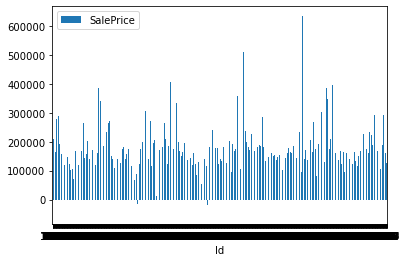

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
workbook = "sample_submission_my.xlsx"

df = pd.read_excel(workbook)

values = df[['Id','SalePrice']]

ax = values.plot.bar(x="Id",y="SalePrice",rot=0)
plt.show()